In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from cntxt import rom_am
from rom_am import ROM
import matplotlib.pyplot as plt
import scipy.interpolate as si

## Loading Data from simulation results

In [2]:
pist_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_fixed_dt.txt")
nnt = pist_pressure.shape[0]
fl_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_field_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho_e = np.loadtxt("../DATA/Fsi_Results/results_rho_e_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho_v = np.loadtxt("../DATA/Fsi_Results/results_rho_v_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_velocity_end = np.loadtxt("../DATA/Fsi_Results/results_v_fixed_dt.txt").reshape((-1,nnt), order = 'F')
fl_rho = np.loadtxt("../DATA/Fsi_Results/results_rho_fixed_dt.txt").reshape((-1,nnt), order = 'F')
delta_t = np.loadtxt("../DATA/Fsi_Results/results_Delta_T_fixed_dt.txt")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho

t = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]
L = 1

In [2]:
pist_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres.txt")
nnt = pist_pressure.shape[0]
fl_pressure = np.loadtxt("../DATA/Fsi_Results/results_pres_field.txt").reshape((-1,nnt), order = 'F')
fl_rho_e = np.loadtxt("../DATA/Fsi_Results/results_rho_e.txt").reshape((-1,nnt), order = 'F')
fl_rho_v = np.loadtxt("../DATA/Fsi_Results/results_rho_v.txt").reshape((-1,nnt), order = 'F')
fl_velocity_end = np.loadtxt("../DATA/Fsi_Results/results_v.txt").reshape((-1,nnt), order = 'F')
fl_rho = np.loadtxt("../DATA/Fsi_Results/results_rho.txt").reshape((-1,nnt), order = 'F')
moving_mesh = np.loadtxt("../DATA/Fsi_Results/results_mesh.txt").reshape((-1,nnt), order = 'F')
delta_t = np.loadtxt("../DATA/Fsi_Results/results_Delta_T.txt")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho
sol_accel = np.loadtxt("../DATA/Fsi_Results/results_m_accel.txt")

t = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]
L = 1
L0 = 1.2

## ----------------------------------------------------------------------------------------------------------------------

## POD Reconstruction

In [3]:
# Training data
X = fl_pressure

In [4]:
pod = ROM(rom="pod")
pod.decompose(X, alg="svd",)

In [5]:
rank = 4
rec_X = pod.approximate(rank)

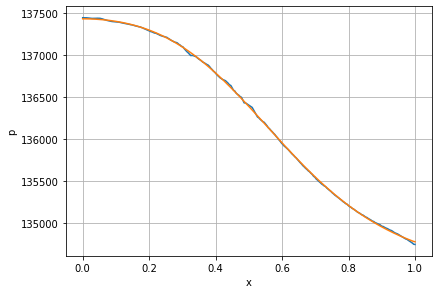

In [6]:
domain = np.linspace(0, L, nx)

plt.plot(domain, X[: , -1]);
plt.plot(domain, rec_X[: ,  -1]);
plt.grid();
plt.tight_layout();

plt.xlabel("x");
plt.ylabel("p");

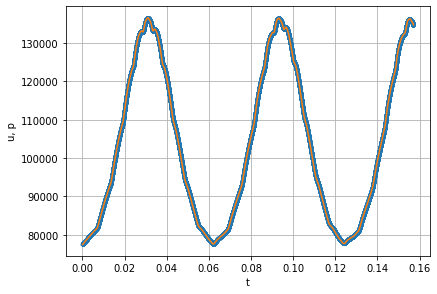

In [7]:
plt.plot(t, X[-1, :], '.');
plt.plot(t, rec_X[-1, :]);
plt.grid();
plt.tight_layout();

plt.xlabel("t");
plt.ylabel("u, p");

## ----------------------------------------------------------------------------------------------------------------------

## DMD Reduction

**Interpolate to fixed time intervals**

In [8]:
# Choose number of equally spaced timesteps 
ntt = 260
dt = (t[-1] - t[0]) / (ntt - 1)
normalized = 0

# Interpolating original data to the new timesteps
target_t = np.linspace(t[0], t[-1], ntt)
target_fl_pressure = si.griddata(t, fl_pressure.T, target_t, method='nearest').T
target_fl_velocity = si.griddata(t, fl_velocity.T, target_t, method='nearest').T
target_fl_m_mesh = si.griddata(t, moving_mesh.T, target_t, method='nearest').T
target_sol_accel = si.griddata(t, sol_accel.T, target_t, method='nearest').T

**Optional : Normalize the data**

In [9]:
normalized = 0
if normalized:
    fl_prs_norm = np.linalg.norm(target_fl_pressure, axis = 1)
    msh_norm = np.linalg.norm(target_fl_m_mesh, axis = 1)
    msh_norm[0] = 1
    fl_velc_norm = np.linalg.norm(target_fl_velocity, axis = 1)
    fl_velc_norm[0] = 1
    sol_accel_norm = np.linalg.norm(target_sol_accel)

    target_fl_pressure = target_fl_pressure / fl_prs_norm[:, np.newaxis]
    target_fl_velocity = target_fl_velocity / fl_velc_norm[:, np.newaxis]
    target_fl_m_mesh = target_fl_m_mesh / msh_norm[:, np.newaxis]
    target_sol_accel = target_sol_accel / sol_accel_norm

**Probe data for training**

In [10]:
# Choose coefficient of time interval(of data) chosen for training
Coeff = 0.33

# Training data (considering moving mesh)
XY_DATA = np.concatenate((target_fl_pressure[:, :int(ntt * Coeff)], target_fl_velocity[:, :int(ntt * Coeff)], 
                          target_fl_m_mesh[:, :int(ntt * Coeff)], ))
X = XY_DATA[:, :-1]
Y = XY_DATA[:, 1::]

# Training data (Disregarding moving mesh)
XY_DATA_2 = np.concatenate((target_fl_pressure[:, :int(ntt * Coeff)], target_fl_velocity[:, :int(ntt * Coeff)]))
X2 = XY_DATA_2[:, :-1]
Y2 = XY_DATA_2[:, 1::]

# Training data (considering moving mesh AND mass acceleration)
XY_DATA_3 = np.concatenate((target_fl_pressure[:, :int(ntt * Coeff)], target_fl_velocity[:, :int(ntt * Coeff)], 
                          target_fl_m_mesh[:, :int(ntt * Coeff)], target_sol_accel[:int(ntt * Coeff)][np.newaxis, :]))
X3 = XY_DATA_3[:, :-1]
Y3 = XY_DATA_3[:, 1::]

**DMD reduction**

In [11]:
rank = 0
dmd = ROM("dmd")
dmd.decompose(X, Y, dt = dt, rank = rank,)

In [12]:
rank = 0
dmd2 = ROM("dmd")
dmd2.decompose(X2, Y2, dt = dt, rank = rank, )

In [13]:
rank = 0
dmd3 = ROM("dmd")
dmd3.decompose(X3, Y3, dt = dt, rank = rank, )

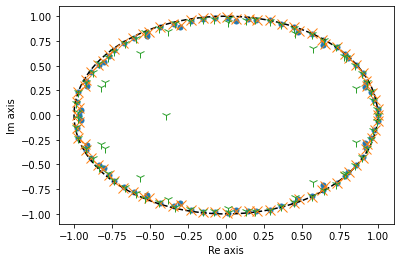

In [14]:
plt.plot(np.real(dmd.lambd), np.imag(dmd.lambd), '.', markersize = 10);
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

plt.plot(np.real(dmd2.lambd), np.imag(dmd2.lambd), 'x', markersize = 10);
plt.plot(np.real(dmd3.lambd), np.imag(dmd3.lambd), '1', markersize = 10, label = r"$$");

## Reconstructing X

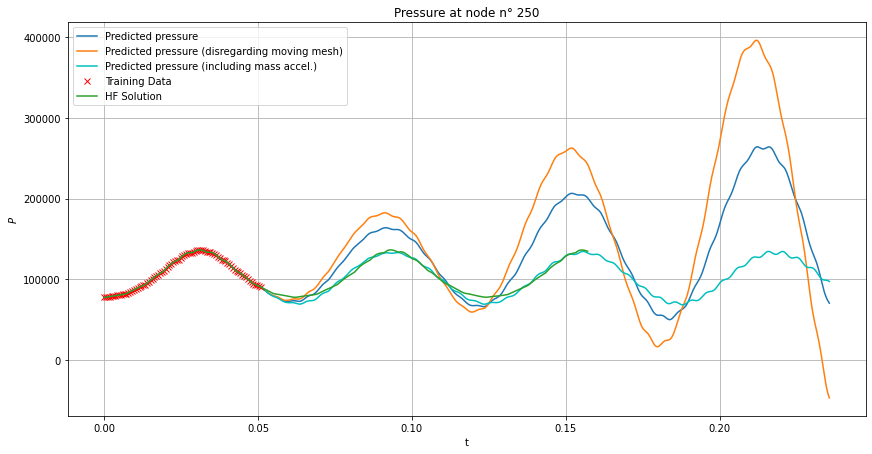

In [15]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1

fig = plt.figure(figsize = (12, 6))
prediction_t = np.concatenate((target_t, np.linspace(target_t[-1] + dt, 1.5 * target_t[-1], int(ntt))))
predicted_X = np.real(dmd.dmd_predict(prediction_t, t1 = t[0], method =0, init = X[:, 0]))
predicted_X2 = np.real(dmd2.dmd_predict(prediction_t, t1 = t[0], method =0, init = X2[:, 0]))
predicted_X3 = np.real(dmd3.dmd_predict(prediction_t, t1 = t[0], method =0, init = X3[:, 0]))

predicted_mesh = predicted_X[2 * nx::, :]
predicted_pressure = predicted_X[:nx, :]
predicted_pressure_nomesh = predicted_X2[:nx, :]
predicted_pressure_accel = predicted_X3[:nx, :]

## ----- In case input data was normalized -----

if normalized:
    predicted_mesh = predicted_mesh * msh_norm[:, np.newaxis]
    predicted_pressure = predicted_pressure * fl_prs_norm[:, np.newaxis]
    predicted_pressure_nomesh = predicted_pressure_nomesh * fl_prs_norm[:, np.newaxis]
    predicted_pressure_accel = predicted_pressure_accel * fl_prs_norm[:, np.newaxis]
    target_fl_pressure = target_fl_pressure * fl_prs_norm[:, np.newaxis]

## ---------------------------------------------

plt.plot(prediction_t, predicted_pressure[-x_n, :], '-', label = "Predicted pressure")
plt.plot(prediction_t, predicted_pressure_nomesh[-x_n, :], '-', label = "Predicted pressure (disregarding moving mesh)")
plt.plot(prediction_t, predicted_pressure_accel[-x_n, :], '-c', label = "Predicted pressure (including mass accel.)")
plt.plot(target_t[: int(ntt * Coeff)], target_fl_pressure[-x_n, :int(ntt * Coeff)], 'xr', label = "Training Data");


plt.plot(t, fl_pressure[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();

plt.xlabel("t");
plt.ylabel("$P$");
plt.title("Pressure at node n° " + str(nx - x_n + 1));

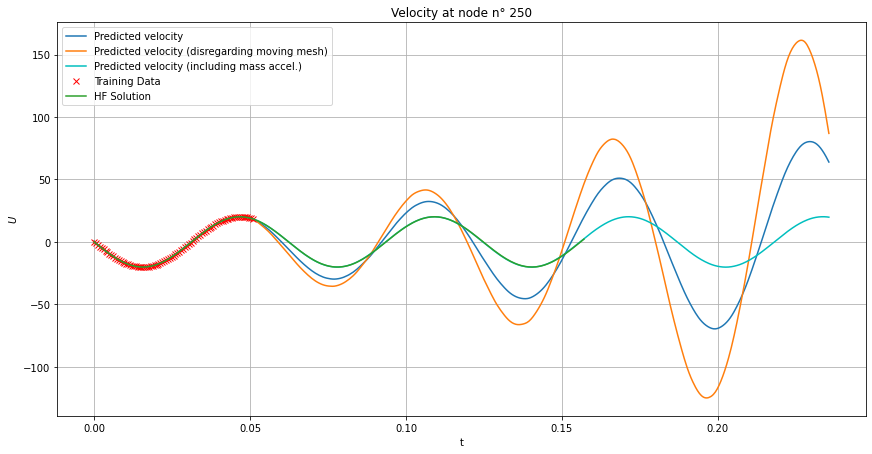

In [16]:
fig = plt.figure(figsize = (12, 6))

predicted_velocity = predicted_X[nx:2*nx, :]
predicted_velocity_nomesh = predicted_X2[nx:2*nx, :]
predicted_velocity_accel = predicted_X3[nx:2*nx, :]

## ----- In case input data was normalized -----

if normalized:
    predicted_velocity = predicted_velocity * fl_velc_norm[:, np.newaxis]
    predicted_velocity_nomesh = predicted_velocity_nomesh * fl_velc_norm[:, np.newaxis]
    predicted_velocity_accel = predicted_velocity_accel * fl_velc_norm[:, np.newaxis]
    target_fl_velocity = target_fl_velocity * fl_velc_norm[:, np.newaxis]

## ---------------------------------------------

plt.plot(prediction_t, predicted_velocity[-x_n, :], '-', label = "Predicted velocity")
plt.plot(prediction_t, predicted_velocity_nomesh[-x_n, :], '-', label = "Predicted velocity (disregarding moving mesh)")
plt.plot(prediction_t, predicted_velocity_accel[-x_n, :], '-c', label = "Predicted velocity (including mass accel.)")
plt.plot(target_t[: int(ntt * Coeff)], target_fl_velocity[-x_n, :int(ntt * Coeff)], 'xr', label = "Training Data");


plt.plot(t, fl_velocity[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();

plt.xlabel("t");
plt.ylabel("$U$");
plt.title("Velocity at node n° " + str(nx - x_n + 1));

## Display

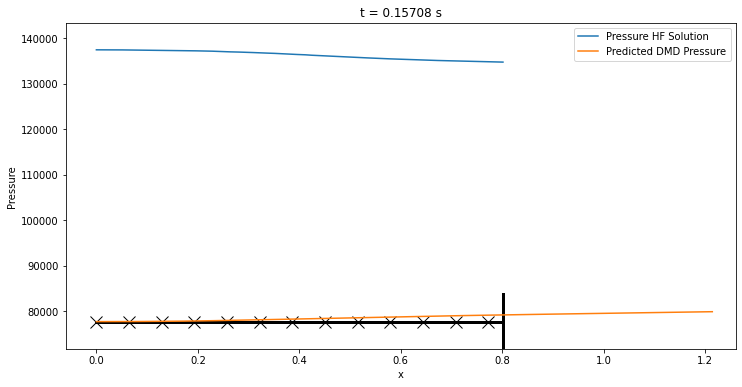

In [26]:
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize = (12, 6))

x = target_fl_m_mesh[:, 0]
line, = ax.plot(x, target_fl_pressure[:, 0], label = "Pressure HF Solution");
thresh = target_fl_pressure[:, 0].min()*.9
line2, = ax.plot(x, thresh * np.ones(x.shape[0]), 'k', linewidth = 3,);
line3, = ax.plot(target_fl_m_mesh[-1, 0] * np.ones(50), np.linspace(thresh * .96, thresh * 1.04, 50), 'k', linewidth = 3,);
line4, = ax.plot(x[::20], thresh * np.ones(x[::20].shape[0]), 'kx', linewidth = 3, markersize = 12);
line5, = ax.plot(x, predicted_pressure[:, 0], label = "Predicted DMD Pressure");
plt.xlabel("x")
plt.ylabel("Pressure")

def animate(i):
    
    plt.title(f"t = {target_t[i]:.5f} s");
    
    length = max(target_fl_pressure[:, i].max(), predicted_pressure[:, i].max())  - min(target_fl_pressure[:, i].min(), predicted_pressure[:, i].min())
    thresh = min(target_fl_pressure[:, i].min(), predicted_pressure[:, i].min()) - .1 * length

    ax.set_ylim(top = max(target_fl_pressure[:, i].max(), predicted_pressure[:, i].max()) + .1 * length, bottom = thresh);

    line.set_xdata(target_fl_m_mesh[:, i])  ;
    line.set_ydata(target_fl_pressure[:, i]) ;
    
    line2.set_xdata(target_fl_m_mesh[:, i])  ;
    line2.set_ydata(thresh + .1 * length) ;
    
    line3.set_xdata(target_fl_m_mesh[-1, i]) ;
    line3.set_ydata(np.linspace(thresh, thresh + length *  .2, 50));
    
    line4.set_xdata(target_fl_m_mesh[:, i][::20]) ; 
    line4.set_ydata(thresh + .1 * length);
    
    line5.set_xdata(predicted_mesh[:, i])  ;
    line5.set_ydata(predicted_pressure[:, i]);
    return line, line2, line3, line4, line5

plt.legend();
ani = animation.FuncAnimation(
    fig, animate, interval=110, blit=False, save_count=target_fl_m_mesh.shape[1]);

# save the animation
ani.save("../References/Pressure_in_Fluid.mp4")

# plt.grid()

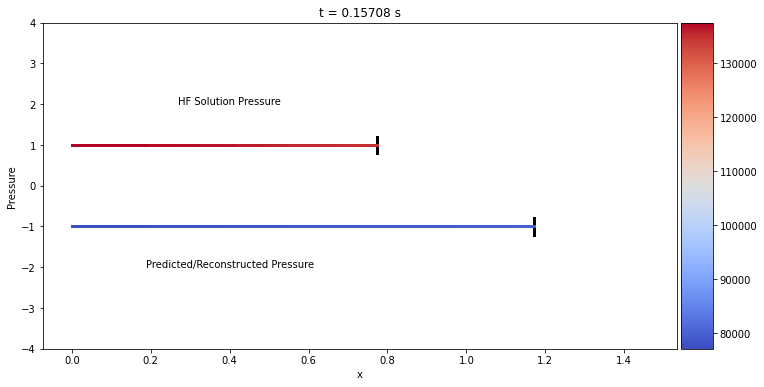

In [27]:
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

n_cut = 10

fig, ax = plt.subplots(figsize = (12, 6))

pres_max = np.abs(target_fl_pressure).max()
pres_min = np.abs(target_fl_pressure).min()

norm = plt.cm.colors.Normalize(vmin=pres_min, vmax=pres_max)
colors = plt.cm.coolwarm(norm(target_fl_pressure[::n_cut, :]))
colors2 = plt.cm.coolwarm(norm(predicted_pressure[::n_cut, :]))


x = target_fl_m_mesh[:, 0][::n_cut]
x2 = predicted_mesh[:, 0][::n_cut]

for j in range(len(x)-1):
    line2, = ax.plot([x[j], x[j+1]], [1, 1], linewidth = 3, color = colors[j, 0, :],);
    line5, = ax.plot([x2[j], x2[j+1]], [-1, -1], linewidth = 3, color = colors2[j, 0, :],);

line3, = ax.plot(target_fl_m_mesh[-1, 0] * np.ones(2), np.linspace(.96, 1.04, 2), 'k', linewidth = 3,);
line4, = ax.plot(predicted_mesh[-1, 0] * np.ones(2), np.linspace(-.96, -1.04, 2), 'k', linewidth = 3,);

plt.xlabel("x")
plt.ylabel("Pressure")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cmap = mpl.cm.coolwarm

ax.text(.4, 2, "HF Solution Pressure", ha = "center")
ax.text(.4, -2, "Predicted/Reconstructed Pressure", ha = "center")

def animate(i):
    x = target_fl_m_mesh[:, i][::n_cut]
    x2 = predicted_mesh[:, i][::n_cut]

    ax.set_title(f"t = {target_t[i]:.5f} s");
    
    ax.set_ylim(top = 4, bottom = -4);

    if i>0:
        ax.plot(target_fl_m_mesh[:, i-1][::n_cut], np.ones(x.shape[0]),  'w', linewidth = 3,);
        ax.plot(predicted_mesh[:, i-1][::n_cut], -np.ones(x.shape[0]),  'w', linewidth = 3,);

    for j in range(len(x)-1):
        line2, = ax.plot([x[j], x[j+1]], [1, 1], linewidth = 3, color = colors[j, i, :]);
        line5, = ax.plot([x2[j], x2[j+1]], [-1, -1], linewidth = 3, color = colors2[j, i, :]);

    line3.set_xdata(x[-1]) ;
    line3.set_ydata(np.linspace(.8, 1.2, 2));
        
    line4.set_xdata(x2[-1]) ;
    line4.set_ydata(np.linspace(-.8, -1.2, 2));
    


    return line2, line3, line4, line5


cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation="vertical")

ani = animation.FuncAnimation(
    fig, animate, interval=110, blit=True, save_count=target_fl_m_mesh.shape[1]);
# save the animation
ani.save("../References/Pressure_in_Fluid_2.mp4")

## Errors

Computing errors between reconstructed pressure values and the high-fidelity solution of pressure, taking into account and comparing the two cases where moving mesh is included and disregarded in the data.

In [23]:
def sample_data(ntt = 260):
    # Choose number of equally spaced timesteps 
    dt = t[-1] / ntt


    # Interpolating original data to the new timesteps
    target_t = np.linspace(t[0], t[-1], ntt)
    target_fl_pressure = si.griddata(t, fl_pressure.T, target_t,).T
    target_fl_velocity = si.griddata(t, fl_velocity.T, target_t,).T
    target_fl_m_mesh = si.griddata(t, moving_mesh.T, target_t,).T
    
    return dt, target_t, target_fl_m_mesh, target_fl_pressure, target_fl_velocity
    
def create_DATA(Coeff, include = 1):
    # include = 1 if moving mesh is included, = 0 otherwise
    # Training data (considering moving mesh)
    ntt = target_fl_pressure.shape[1]
    if include == 1:
        XY_DATA = np.concatenate((target_fl_pressure[:, :int(ntt * Coeff)], 
                                  target_fl_velocity[:, :int(ntt * Coeff)], target_fl_m_mesh[:, :int(ntt * Coeff)]))
    elif include == 2:
        XY_DATA = np.concatenate((target_fl_pressure[:, :int(ntt * Coeff)], 
                                  target_fl_velocity[:, :int(ntt * Coeff)], target_fl_m_mesh[:, :int(ntt * Coeff)],
                                  target_sol_accel[:int(ntt * Coeff)].reshape((1, -1))))
    else:
        XY_DATA = np.concatenate((target_fl_pressure[:, :int(ntt * Coeff)], target_fl_velocity[:, :int(ntt * Coeff)]))
    
    X = XY_DATA[:, :-1]
    Y = XY_DATA[:, 1::]
    return X, Y


def predict_by_DMD(X, Y, include  = 0):
    
    rank = 100
    dmd = ROM("dmd")
    dmd.decompose(X, Y, dt = dt, rank = rank, sorting="abs")
    
    prediction_t = t
    predicted_X = np.real(dmd.dmd_predict(prediction_t, t1 = t[0]))
    
    predicted_pressure = predicted_X[: nx, :]
    predicted_velocity = predicted_X[nx : 2 * nx, :]

    if include == 1:
        predicted_mesh = predicted_X[2*nx ::, :]
        return predicted_mesh, predicted_pressure, predicted_velocity
    elif include == 2:
        predicted_mesh = predicted_X[2*nx : 3*nx, :]
        return predicted_mesh, predicted_pressure, predicted_velocity
    else:
        return predicted_pressure, predicted_velocity

def compute_error(predicted, reference):
    
#     err = (np.sqrt(((predicted[-1, :] - reference[-1, :])**2).sum())/np.sqrt((reference[-1, :]**2).sum()))
    err = np.sqrt((np.linalg.norm(predicted - reference, axis = 0)**2).sum())\
        /np.sqrt((np.linalg.norm(reference, axis = 0)**2).sum())

    return err

In [24]:
include = 1
Coeff_list = [.33, .4, .5, .75, .8,]
err = np.zeros(len(Coeff_list))
err3 = np.zeros(len(Coeff_list))
ntt_ = t.shape[0]

for i in range(len(Coeff_list)):
    Coeff = Coeff_list[i]
    dt, target_t, target_fl_m_mesh, target_fl_pressure, target_fl_velocity = sample_data()
    X, Y = create_DATA(Coeff_list[i], include)
    predicted_mesh, predicted_pressure, predicted_velocity = predict_by_DMD(X, Y, include)
    err[i] = compute_error(predicted_pressure[:, int(ntt_ * Coeff)::], fl_pressure[:, int(ntt_ * Coeff)::])
    err3[i] = compute_error(predicted_velocity[:, int(ntt_ * Coeff)::], fl_velocity[:, int(ntt_ * Coeff)::])
    
include = 0
err2 = np.zeros(len(Coeff_list))
err4 = np.zeros(len(Coeff_list))

for i in range(len(Coeff_list)):
    Coeff = Coeff_list[i]
    dt, target_t, target_fl_m_mesh, target_fl_pressure, target_fl_velocity = sample_data()
    X, Y = create_DATA(Coeff_list[i], include)
    predicted_pressure, predicted_velocity = predict_by_DMD(X, Y, include)
    err2[i] = compute_error(predicted_pressure[:, int(ntt_ * Coeff)::], fl_pressure[:, int(ntt_ * Coeff)::])
    err4[i] = compute_error(predicted_velocity[:, int(ntt_ * Coeff)::], fl_velocity[:, int(ntt_ * Coeff)::])

include = 2
err5 = np.zeros(len(Coeff_list))
err6 = np.zeros(len(Coeff_list))

for i in range(len(Coeff_list)):
    Coeff = Coeff_list[i]
    dt, target_t, target_fl_m_mesh, target_fl_pressure, target_fl_velocity = sample_data()
    X, Y = create_DATA(Coeff_list[i], include)
    predicted_mesh, predicted_pressure, predicted_velocity = predict_by_DMD(X, Y, include)
    err5[i] = compute_error(predicted_pressure[:, int(ntt_ * Coeff)::], fl_pressure[:, int(ntt_ * Coeff)::])
    err6[i] = compute_error(predicted_velocity[:, int(ntt_ * Coeff)::], fl_velocity[:, int(ntt_ * Coeff)::])

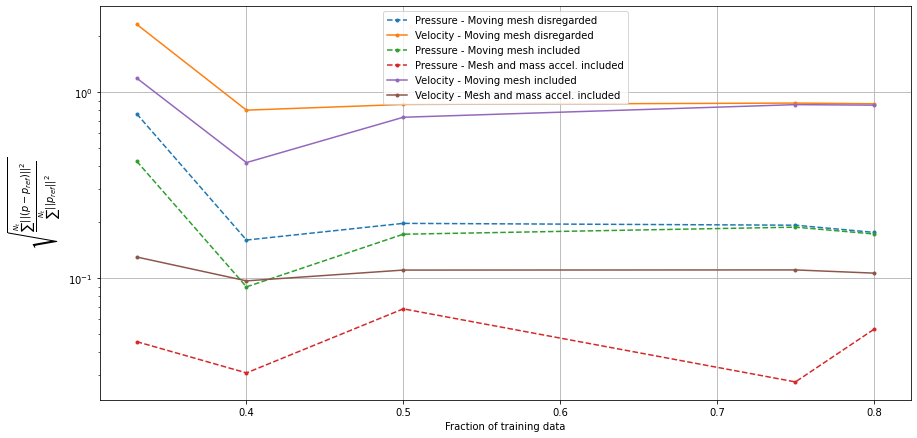

In [25]:
figure, ax  = plt.subplots(figsize = (12, 6))

plt.semilogy(Coeff_list, err2, '.--', label = "Pressure - Moving mesh disregarded");
plt.semilogy(Coeff_list, err4, '.-', label = "Velocity - Moving mesh disregarded");

plt.semilogy(Coeff_list, err, '.--', label = "Pressure - Moving mesh included");
plt.semilogy(Coeff_list, err5, '.--', label = "Pressure - Mesh and mass accel. included");

plt.semilogy(Coeff_list, err3, '.-', label = "Velocity - Moving mesh included");
plt.semilogy(Coeff_list, err6, '.-', label = "Velocity - Mesh and mass accel. included");

plt.grid();
plt.tight_layout();
plt.ylabel(r"$\sqrt{\frac{\sum^{N_t}||({p} - p_{ref})||^2}{\sum^{N_t}||p_{ref}||^2}}$", fontsize = 14);
plt.xlabel("Fraction of training data")
plt.legend();